# Main Focus of the Notebook: Extract pixel values from the alternate channel based on our main channel 

In [1]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from skimage import io
import numpy as np 

plt.rcParams["font.family"] = ""

## Important Functions Below 

**Function 1** 

The following function takes in parameters 
1. raw target image/movie for which we want to extract the information for
2. centers of the spots which we have from our original detected image 
3. Fixed radius for all the spots (radius is same for all the spots)
4. offset for y and x axis if needed

In [2]:
def extract_pixels_data(target_image, frame_centers, radii, offset):
    particle_stats = []
    mean = []
    maximum = []
    minimum = []
    pixel_values = []
    max_loc = []
    voxel_sum_array = []
    max_z, max_y, max_x = target_image[0].shape  # Assuming image is a 3D numpy array
    radius_z = radii[0]
    radius_y = radii[1]
    radius_x = radii[2]

    for coords in frame_centers:
        #print('current coordinates are: ', coords)
        frame = int(coords[0])
        z = coords[1]
        y = coords[2] - offset[0]
        x = coords[3] - offset[1]
        

        # Ensure lower bounds
        z_start = int(max(0, z - radius_z))
        y_start = int(max(0, y - radius_y))
        x_start = int(max(0, x - radius_x))

        # Ensure upper bounds
        z_end = int(min(max_z, z + radius_z + 1))
        y_end = int(min(max_y, y + radius_y + 1))
        x_end = int(min(max_x, x + radius_x + 1))

        # Extract relevant pixels
        extracted_pixels = target_image[frame,z_start:z_end, y_start:y_end, x_start:x_end]
        #print('shape of extracted pixels is ', extracted_pixels.shape)
        
        # Exclude pixels with value 0 before calculating mean
        non_zero_pixels = extracted_pixels[extracted_pixels != 0]
        
        if non_zero_pixels.size > 0:
            # Calculate statistics
            mean_value = np.mean(non_zero_pixels)
            max_value = np.max(non_zero_pixels)
            voxel_sum = np.sum(non_zero_pixels)
            
            # Get coordinates of the maximum value
            max_index = np.unravel_index(np.argmax(extracted_pixels), extracted_pixels.shape)
            max_coords = (z_start + max_index[0], y_start + max_index[1], x_start + max_index[2])
            min_value = np.min(non_zero_pixels)
            
            mean.append(mean_value)
            maximum.append(max_value)
            max_loc.append(max_coords)
            minimum.append(min_value)
            pixel_values.append(extracted_pixels)
            voxel_sum_array.append(voxel_sum)
        else:
            # If all pixels are 0, handle this case as needed
            mean.append(np.nan)  # Use NaN or any other suitable value
            maximum.append(0)
            minimum.append(0)
            pixel_values.append(extracted_pixels)
            print('zero pixels here')
        
    #particle_stats = np.array(particle_stats)
    return mean,maximum,minimum,pixel_values,max_loc,voxel_sum_array


**Function 2** 

The following function takes in parameters 
1. raw target image/movie for which we want to extract the information for
2. give names of the columns from the dataframe which contain the center of the detected spots 
3. Pass the main dataframe returned from laptrack 
4. offset for y and x axis if needed


This variant uses changing sigma values for each detected spot whereas the above variant uses a fixed radius for all spots.

In [3]:
def extract_pixels_data_2(raw_image, col_names, dataframe, offset):
    particle_stats = []
    mean = []
    maximum = []
    minimum = []
    pixel_values = []
    max_loc = []
    max_z, max_y, max_x = raw_image[0].shape  # Assuming image is a 3D numpy array

    for i in range(len(dataframe)):
        #print('current coordinates are: ', coords)
        frame = int(dataframe.loc[i,'frame'])
        z = dataframe.loc[i, col_names[0]]
        y = dataframe.loc[i, col_names[1]]
        x = dataframe.loc[i, col_names[2]]
        radius_z = dataframe.loc[i,'sigma_z']
        radius_y = dataframe.loc[i,'sigma_y']
        radius_x = dataframe.loc[i,'sigma_x']
        

        # Ensure lower bounds
        z_start = int(max(0, z - radius_z))
        y_start = int(max(0, y - radius_y))
        x_start = int(max(0, x - radius_x))

        # Ensure upper bounds
        z_end = int(min(max_z, z + radius_z + 1))
        y_end = int(min(max_y, y + radius_y + 1))
        x_end = int(min(max_x, x + radius_x + 1))

        # Extract relevant pixels
        extracted_pixels = raw_image[frame,z_start:z_end, y_start:y_end, x_start:x_end]
        
        # Exclude pixels with value 0 before calculating mean
        non_zero_pixels = extracted_pixels[extracted_pixels != 0]
        
        if non_zero_pixels.size > 0:
            # Calculate statistics
            mean_value = np.mean(non_zero_pixels)
            max_value = np.max(non_zero_pixels)
            voxel_sum = np.sum(non_zero_pixels)
            
            # Get coordinates of the maximum value
            max_index = np.unravel_index(np.argmax(extracted_pixels), extracted_pixels.shape)
            max_coords = (z_start + max_index[0], y_start + max_index[1], x_start + max_index[2])
            min_value = np.min(non_zero_pixels)
            
            mean.append(mean_value)
            maximum.append(max_value)
            max_loc.append(max_coords)
            minimum.append(min_value)
            pixel_values.append(extracted_pixels)
        else:
            # If all pixels are 0, handle this case as needed
            mean.append(np.nan)  # Use NaN or any other suitable value
            maximum.append(np.nan)
            minimum.append(np.nan)
            temp = (np.nan, np.nan, np.nan)
            max_loc.append(temp)
            pixel_values.append(extracted_pixels)
            #print(len(non_zero_pixels))
            print(f'{i},zero pixels here')
        
    #particle_stats = np.array(particle_stats)
    return mean,maximum,minimum,pixel_values,max_loc


**Function 3**

This function calculates the voxel sum around a spot. It uses flexible sigma values for each spot

In [4]:
def voxel_sum(dataframe,col_names, raw_image):
    max_z, max_y, max_x = raw_image[0].shape  # Assuming image is a 3D numpy array
    voxel_sum_array = []
    pixel_values = []
    
    for i in range(len(dataframe)):
        frame = int(dataframe.loc[i,'frame'])
        z = dataframe.loc[i,col_names[0]]
        y = dataframe.loc[i,col_names[1]]
        x = dataframe.loc[i,col_names[2]]
        radius_z = dataframe.loc[i,'sigma_z']
        radius_y = dataframe.loc[i,'sigma_y']
        radius_x = dataframe.loc[i,'sigma_x']
        

        # Ensure lower bounds
        z_start = int(max(0, z - radius_z))
        y_start = int(max(0, y - radius_y))
        x_start = int(max(0, x - radius_x))

        # Ensure upper bounds
        z_end = int(min(max_z, z + radius_z + 1))
        y_end = int(min(max_y, y + radius_y + 1))
        x_end = int(min(max_x, x + radius_x + 1))

        # Extract relevant pixels
        extracted_pixels = raw_image[frame,z_start:z_end, y_start:y_end, x_start:x_end]
        #print('shape of extracted pixels is ', extracted_pixels.shape)
        
        # Exclude pixels with value 0 before calculating mean
        non_zero_pixels = extracted_pixels[extracted_pixels != 0]
        
        if non_zero_pixels.size > 0:
            # Calculate statistics
            voxel_sum = np.sum(non_zero_pixels)
            
            # Get coordinates of the maximum value
            voxel_sum_array.append(voxel_sum)
            pixel_values.append(non_zero_pixels)
        else:
            # If all pixels are 0, handle this case as needed
            voxel_sum_array.append(np.nan)  # Use NaN or any other suitable value
            print(f'{i}, zero pixels here')
        
    return voxel_sum_array,pixel_values


**Function 4**

The below variant for voxel sum uses a fixed radii value for voxel sum 

In [5]:
def voxel_sum_2(dataframe,col_names, raw_image, radii):
    max_z, max_y, max_x = raw_image[0].shape  # Assuming image is a 3D numpy array
    voxel_sum_array = []
    pixel_values = []
    radius_z = radii[0]
    radius_y = radii[1]
    radius_x = radii[2]
    
    for i in range(len(dataframe)):
        frame = int(dataframe.loc[i,'frame'])
        z = dataframe.loc[i,col_names[0]]
        y = dataframe.loc[i,col_names[1]]
        x = dataframe.loc[i,col_names[2]]
        

        # Ensure lower bounds
        z_start = int(max(0, z - radius_z))
        y_start = int(max(0, y - radius_y))
        x_start = int(max(0, x - radius_x))

        # Ensure upper bounds
        z_end = int(min(max_z, z + radius_z + 1))
        y_end = int(min(max_y, y + radius_y + 1))
        x_end = int(min(max_x, x + radius_x + 1))

        # Extract relevant pixels
        extracted_pixels = raw_image[frame,z_start:z_end, y_start:y_end, x_start:x_end]
        #print('shape of extracted pixels is ', extracted_pixels.shape)
        
        # Exclude pixels with value 0 before calculating mean
        non_zero_pixels = extracted_pixels[extracted_pixels != 0]
        
        if non_zero_pixels.size > 0:
            # Calculate statistics
            voxel_sum = np.sum(non_zero_pixels)
            
            # Get coordinates of the maximum value
            voxel_sum_array.append(voxel_sum)
            pixel_values.append(non_zero_pixels)
        else:
            # If all pixels are 0, handle this case as needed
            voxel_sum_array.append(np.nan)  # Use NaN or any other suitable value
            print(f'{i}, zero pixels here')
        
    return voxel_sum_array,pixel_values


**Function 5**

In [6]:
# Function to check if coordinates are within the range
def check_range(row):
    x_range = (row['mu_x'] - 2 * row['sigma_x'], row['mu_x'] + 2 * row['sigma_x'])
    y_range = (row['mu_y'] - 2 * row['sigma_y'], row['mu_y'] + 2 * row['sigma_y'])
    z_range = (row['mu_z'] - 2 * row['sigma_z'], row['mu_z'] + 2 * row['sigma_z'])

    return (
        x_range[0] <= row['c2_peak_x'] <= x_range[1] and
        y_range[0] <= row['c2_peak_y'] <= y_range[1] and
        z_range[0] <= row['c2_peak_z'] <= z_range[1]
    )

#implementation example
#track_df['within_range'] = track_df.apply(check_range, axis=1)

In [7]:
# Replace 'your_file.tif' with the path to your 4D TIFF file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/Channel2_complete.tif'

# Load the TIFF file using skimage
c2_raw = io.imread(file_path)

In [8]:
# Replace 'your_file.tif' with the path to your 4D TIFF file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/Channel3_complete.tif'

# Load the TIFF file using skimage
c3_raw = io.imread(file_path)

In [9]:
path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/track_df_c3_cleaned.pkl'
track_df = pd.read_pickle(path)

In [10]:
c2_raw.shape
#(t,z,y,x)

(130, 75, 258, 275)

In [11]:
c3_raw.shape

(130, 75, 258, 275)

## Calculating values for channel 2 based on available information from channel 3

In [12]:
offset = [0,0]
col_names = ['mu_z', 'mu_y', 'mu_x']
mean,maximum,minimum,pixel_values,max_loc = extract_pixels_data_2(c2_raw, col_names, track_df, offset)

2622,zero pixels here
3057,zero pixels here
17403,zero pixels here
18660,zero pixels here
20576,zero pixels here
29684,zero pixels here
36704,zero pixels here
37799,zero pixels here
37800,zero pixels here
38508,zero pixels here
38509,zero pixels here
40624,zero pixels here
43687,zero pixels here
46238,zero pixels here


In [13]:
print(len(minimum))

49867


In [14]:
track_df.head()

,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,tree_id,track_id
0,0,0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0,0,0
1,0,1,191.000000,36.0,88.0,1.0,2.0,1.0,2.0,0,1,1
2,0,2,231.007679,40.0,141.0,1.0,2.0,2.0,2.0,0,2,2
3,0,3,185.152538,40.0,58.0,1.0,2.0,1.0,3.0,0,3,3
4,0,4,202.000000,46.0,73.0,1.0,2.0,2.0,3.0,0,4,4


In [15]:
max_loc = np.array(max_loc)

In [16]:
track_df['c2_amp'] = mean
track_df['c2_peak'] = maximum
track_df['c2_peak_x'] = max_loc[:,2]
track_df['c2_peak_y'] = max_loc[:,1]
track_df['c2_peak_z'] = max_loc[:,0]

# Calculate the mean amplitude around c3 peak 

In [17]:
col_names = ['mu_z', 'mu_y', 'mu_x']
mean_c3,maximum_c3,minimum_c3,pixel_values_c3,max_loc_c3 = extract_pixels_data_2(c3_raw, col_names, track_df, offset)

2622,zero pixels here
3057,zero pixels here
17403,zero pixels here
18660,zero pixels here
29684,zero pixels here
36704,zero pixels here
37799,zero pixels here
37800,zero pixels here
38508,zero pixels here
38509,zero pixels here
40624,zero pixels here
43687,zero pixels here
46238,zero pixels here


In [18]:
track_df['c3_mean_amp'] = mean_c3

# Now consider volume around the max amp coordinate and take mean for that 

In [19]:
col_names = ['c2_peak_z', 'c2_peak_y', 'c2_peak_x']
peak_mean,maxima,_,_,_ = extract_pixels_data_2(c2_raw, col_names, track_df, offset)

7499,zero pixels here
10562,zero pixels here
16139,zero pixels here


In [20]:
track_df['c2_peak_mean'] = peak_mean

# Now calculate and add voxel sum for both channels 

In [21]:
col_names = ['c2_peak_z', 'c2_peak_y', 'c2_peak_x']
radii = [4,2,2]
voxel_sum_array, _ = voxel_sum_2(track_df,col_names,c2_raw, radii)

In [22]:
#calculated around the peak value coordinates
track_df['c2_voxel_sum'] = voxel_sum_array

In [23]:
col_names = ['mu_z', 'mu_y', 'mu_x']
radii = [4,2,2]
voxel_sum_array_c3, _ = voxel_sum_2(track_df,col_names, c3_raw, radii)

In [24]:
track_df['c3_voxel_sum'] = voxel_sum_array_c3

In [25]:
track_df

,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,...,track_id,c2_amp,c2_peak,c2_peak_x,c2_peak_y,c2_peak_z,c3_mean_amp,c2_peak_mean,c2_voxel_sum,c3_voxel_sum
0,0,0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0,...,0,122.947826,152.0,9.0,14.0,2.0,163.682353,125.500000,11295,13913
1,0,1,191.000000,36.0,88.0,1.0,2.0,1.0,2.0,0,...,1,116.233333,143.0,34.0,87.0,2.0,138.233333,114.826667,20068,19928
2,0,2,231.007679,40.0,141.0,1.0,2.0,2.0,2.0,0,...,2,122.330000,142.0,41.0,142.0,0.0,153.940000,122.853333,15316,22805
3,0,3,185.152538,40.0,58.0,1.0,2.0,1.0,3.0,0,...,3,117.626667,142.0,42.0,59.0,0.0,141.280000,118.016667,14557,20358
4,0,4,202.000000,46.0,73.0,1.0,2.0,2.0,3.0,0,...,4,115.112000,141.0,45.0,74.0,3.0,147.768000,115.502857,23194,21963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49862,129,300,177.830039,160.0,133.0,72.0,2.0,2.0,3.0,129,...,18919,120.153333,146.0,161.0,135.0,70.0,143.660000,118.211429,26421,24970
49863,129,301,179.000000,201.0,207.0,71.0,2.0,1.0,3.0,129,...,18920,115.380952,140.0,203.0,207.0,68.0,130.676190,118.647619,26906,26313
49864,129,302,274.813463,219.0,45.0,71.0,2.0,2.0,2.0,129,...,18921,139.080000,181.0,219.0,43.0,73.0,202.216000,143.040000,21248,38855
49865,129,303,175.445348,231.0,219.0,71.0,3.0,2.0,2.0,129,...,18922,122.320000,156.0,228.0,218.0,72.0,131.234286,126.177143,21927,26220


In [30]:
track_df.columns

Index(['frame', 'index', 'amplitude', 'mu_x', 'mu_y', 'mu_z', 'sigma_x',
       'sigma_y', 'sigma_z', 'frame_y', 'tree_id', 'track_id', 'c2_amp',
       'c2_peak', 'c2_peak_x', 'c2_peak_y', 'c2_peak_z', 'c3_mean_amp',
       'c2_peak_mean', 'c2_voxel_sum', 'c3_voxel_sum'],
      dtype='object')

In [36]:
temp = track_df[['frame', 'amplitude', 'mu_x', 'mu_y', 'mu_z', 'sigma_x',
       'sigma_y', 'sigma_z', 'track_id',
       'c2_peak', 'c3_mean_amp',
       'c2_peak_mean', 'c2_voxel_sum', 'c3_voxel_sum']]

In [37]:
temp[temp['track_id']==40]

,frame,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,track_id,c2_peak,c3_mean_amp,c2_peak_mean,c2_voxel_sum,c3_voxel_sum
40,0,315.620370,138.0,238.0,1.0,2.0,1.0,4.0,40,193.0,221.011111,146.816667,28369,30144
462,1,329.716134,138.0,238.0,2.0,2.0,1.0,3.0,40,179.0,221.911111,141.322222,23133,34298
913,2,328.000000,138.0,238.0,3.0,1.0,1.0,3.0,40,185.0,216.349206,139.777778,29082,36573
1331,3,291.509211,138.0,238.0,2.0,2.0,1.0,3.0,40,190.0,202.322222,134.742857,25668,31871
1755,4,315.333333,137.0,238.0,2.0,2.0,1.0,2.0,40,181.0,201.080000,136.520000,22675,30696
2246,5,190.486608,137.0,238.0,4.0,2.0,1.0,6.0,40,184.0,175.630303,135.511111,23277,38660


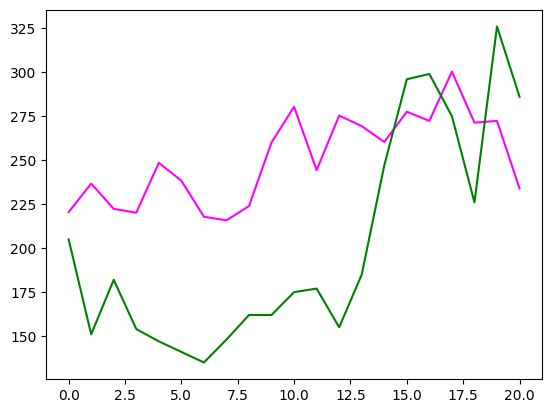

In [47]:
temp_2 = temp[temp['track_id']==91]
plt.plot(temp_2['frame'], temp_2['amplitude'], label = 'Channel 3', color = 'magenta')
plt.plot(temp_2['frame'], temp_2['c2_peak'], label = 'Channel 2', color = 'green')

## Column Name Meanings 
1. **amplitude**: peak amplitude for channel 3 
2. **c2_amp**: mean amplitude for channel 2 when compared with channel 3 pixels (mu_x,mu_y,mu_z)
3. **c2_peak**: highest amplitude in channel 2 for the given volume 
4. **c2_peak_x, c2_peak_y, c2_peak_z**: The coordinates for the peak value in channel 2 for the given volume 
5. **c2_peak_mean**: this is the mean value of amplitude for channel 2 found around the c2_peak_x, c2_peak_y and c2_peak_z. This is possibily different that c2_amp because an offset might be present between channel 2 and channel 3, In c2_amp the mean is found around the pixel values for the max of channel 3. Whereas c2_peak_mean is found around the peak of channel 2 for the volume overlapping channel 3.
6. **c3_mean_amp**: this is the mean for the given volume around the peak channel 3 value. Uses mu_x,mu_y,mu_z as the center and sigma_x,sigma_y,sigma_z to calculate the spread 
7. **c2_peak_mean**: This is the mean around the peak value and uses sigma values from channel 3 to construct the volume. A fixed radius can also be provided. 
8. **c2_voxel_sum**: This is the sum of pixel values around the peak value of channel 2. Uses c2_peak_x, c2_peak_y, c2_peak_z as center and a fixed radius. Option to use variable sigma/radi also exists 
9. **c3_voxel_Sum**: This is the sum of pixel values around the peak value of channel 3. Uses mu_x, mu_y, mu_z as center and a fixed radius. Option to use variable sigma/radi also exists 



In [26]:
#track_df.to_pickle('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/track_df_updated.pkl')

In [27]:
offset = [0,0]
col_names = ['mu_z', 'mu_y', 'mu_x']
mean,maximum,minimum,pixel_values,max_loc = extract_pixels_data_2(c3_raw, col_names, track_df, offset)

2622,zero pixels here
3057,zero pixels here
17403,zero pixels here
18660,zero pixels here
29684,zero pixels here
36704,zero pixels here
37799,zero pixels here
37800,zero pixels here
38508,zero pixels here
38509,zero pixels here
40624,zero pixels here
43687,zero pixels here
46238,zero pixels here


In [28]:
maximum[35691]

222

In [29]:
np.mean(pixel_values[35691])

152.16